The columns from left to right are name, hr, sigma_hr, T90 (or T50), sigma_T90

I suggest you work with T90.

Also note that if you have upgraded your sklearn, you will need to upgrade your codes to 

as GMM is now GaussianMixtureModels etc.

You can do two tests

1) without any outlier rejection

2) rejecting datapoints with large errors (with  rejecting values with error/value > 30% 

you can also try using Extreme Deconvolution (which accounts for errors while using GMM)

In [6]:
import pandas as pd
import numpy as np
import math
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
#from astroML.plotting.tools import draw_ellipse
import itertools
from scipy import linalg
import matplotlib as mpl
from matplotlib.colors import LogNorm
from sklearn import mixture
from xdgmm import XDGMM
# from astroML.density_estimation import XDGMM

In [7]:
arr = np.genfromtxt("hrdata_10yr_T90_Final_w_err copy.txt", dtype=float,delimiter = "\t")
print(len(arr))

2330


In [9]:
t90=[]
hr=[]
dt90=[]
dhr=[]
COLUMN_T90_ERROR = 4
COLUMN_T90 = 3
COLUMN_HR_ERROR = 2
COLUMN_HR = 1
for i in range(len(arr)):
    if arr[i][3] > 0 and arr[i][1] > 0:
        t90.append(math.log(arr[i][3]))
        hr.append(math.log(arr[i][1]))
        dhr.append(arr[i][2] / arr[i][1])
        dt90.append((arr[i][4]/arr[i][3]))
print(len(dt90))

2329


In [10]:
# stack the data 
X = np.vstack([t90, hr]).T
X = X[~np.isnan(X).any(axis=1)]
X = X[np.isfinite(X).any(axis=1)]

#change list to matrix
mat_dt90 = np.zeros(len(dt90))
mat_dhr = np.zeros(len(dhr))
for i in range(len(dhr)):
    mat_dt90[i] = dt90[i]
    mat_dhr[i] = dhr[i]

# stack data error
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([mat_dt90**2, mat_dhr**2]).T

In [11]:
# Define the range of component numbers, and get ready to compute the BIC for each one:
param_range = np.arange(1,6)
xdgmm = XDGMM()


In [18]:
bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(X, Xerr, param_range)

N = 1 , BIC = 13406.952679253236
N = 2 , BIC = 13036.841864432005
N = 3 , BIC = 13039.04293994136
N = 4 , BIC = 13084.891678461834


/usr/local/lib/python2.7/dist-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


N = 5 , BIC = 13114.473580954555


In [16]:
# aic, optimal_n_comp, lowest_aic = xdgmm.aic_test(X, Xerr, param_range)
def aic(X, Xerr,n_components,xdgmm):
    logprob, _ = xdgmm.score_samples(X, Xerr)
    ndim = xdgmm.mu.shape[1]
    cov_params = n_components * ndim * (ndim + 1) / 2.
    mean_params = ndim * n_components
    n_params = int(cov_params + mean_params + n_components - 1)

    return -2 * logprob.sum() + 2 * n_params



In [21]:
import numpy as np
xdgmm = XDGMM()
param_range = np.arange(1,6)
aics = np.array([])
lowest_aic = np.infty
optimal_n_comp = 0
for n_components in param_range:
    n = n_components
    xdgmm.fit(X, Xerr)
    aics = np.append(aics, aic(X, Xerr,n,xdgmm))
    print "N =", n_components, ", AIC =", aics[-1]
    if aics[-1] < lowest_aic:
        optimal_n_comp = n_components
        lowest_aic = aics[-1]



N = 1 , AIC = 13378.186707903815
N = 2 , AIC = 13390.186707903815
N = 3 , AIC = 13402.186707903815
N = 4 , AIC = 13414.186707903815
N = 5 , AIC = 13426.186707903815


https://www.astroml.org/book_figures/chapter6/fig_stellar_XD.html

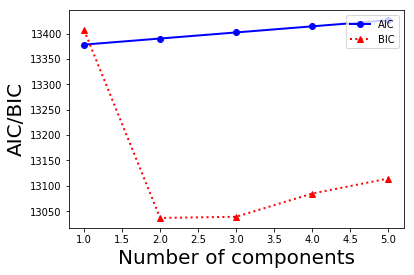

In [22]:
plt.plot(param_range, aics, '-k', label='AIC',color ='blue', marker='o',lw=2)
plt.plot(param_range, bic, ':k', label='BIC', color = 'red', marker='^',lw=2)
plt.legend(loc=1)
plt.xlabel('Number of components',size=20 )
plt.ylabel('AIC/BIC', size=20)
plt.show()